In [1]:
!pwd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))# デフォルトは75%

import sys
sys.executable

/c/Users/shingo/jupyter_notebook/tfgpu_py36_work/02_keras_py/experiment


'C:\\Users\\shingo\\Anaconda3\\envs\\tfgpu20\\python.exe'

# multiclass model

#### 犬猫画像は以下のサイトから取得できた
- https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765


#### import

In [2]:
# モジュールimport
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import plot_log, util
from model import tf_define_model as define_model
from model import tf_my_callback as my_callback
from model import tf_lr_finder as lr_finder
from model import tf_pooling as pooling
from transformer import tf_my_generator as my_generator
from transformer import tf_get_train_valid_test as get_train_valid_test
from predicter import tf_grad_cam as grad_cam
from predicter import tf_base_predict as base_predict
from predicter import roc_curve, conf_matrix, ensemble_predict

from tensorflow import keras
keras.backend.clear_session()

import glob, time, pathlib
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))# 75%

#### parameters

In [3]:
# 出力ディレクトリ
output_dir = r'D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test'
os.makedirs(output_dir, exist_ok=True)

# 入力ディレクトリ
train_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train'
train_samples = len(util.find_img_files(train_data_dir))

validation_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\validation'
val_samples = len(util.find_img_files(validation_data_dir))

test_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\test'
test_samples = len(util.find_img_files(test_dir))

gpu_num = 0# "0,1,2,3"

# 分類クラス
class_name = sorted([str(pathlib.Path(dir_name).name) for dir_name in glob.glob(train_data_dir+'/*')])#['Cat', 'Dog']
classes = class_name
nb_classes = len(classes)

# エポック数、バッチサイズ
num_epoch = 30#2
batch_size = 50
val_batch_size = 50
test_batch_size = 50

# 入力層のサイズ
img_rows, img_cols, channels = 100, 100, 3

# finetuning model
choice_model = 'VGG16'#'EfficientNet'#'InceptionV3'
trainable = 15#249#'all'
is_skip_bn = True
model_path = None

# 全結合層
fcs = [256]
drop = 0.5
is_add_batchnorm = True#False
l2_rate = 1e-4

# optimizer
choice_optim='sgd'
lr = 0.1 * batch_size / 128
lr_factor = 0.01
    
# data augmentation
rescale = 1.0/255.0
#width_shift_range = 0.2
#height_shift_range = 0.2
#horizontal_flip = True
#vertical_flip = True
#shear_range = 20
#zoom_range_min = 0.8
#zoom_range_max = 1.2
#rotation_range = 20
#channel_shift_range = 5.
#brightness_range_min = 0.3
#brightness_range_max = 1.0
#mix_up_alpha = 0.2# mixup alpha
random_crop = [img_rows, img_cols]# random_crop size
random_erasing_prob = 0.5 # random_erasing 確率
#random_erasing_maxpixel = 255
ricap_beta = 0.3 # RICAP beta
ricap_use_same_random_value_on_batch = True # Trueとすれば論文と同じように「ミニバッチ間で共通の乱数を使う例」。Falseにすれば、「サンプル間で別々の乱数を使う例」
#is_kuzushiji_gen = True # 下山さんが使っていたAutoAugmentのデフォルト？変換入れるか
randaugment_N, randaugment_M = 3, 4 # Rand_Augment

In [4]:
# my_IDG_optionsに値詰める。papermillで実行した時でもうまくいくようにする

gpus = str(gpu_num)

if 'zoom_range_min' in list(locals().keys()) and 'zoom_range_max' in list(locals().keys()):
    zoom_range = [zoom_range_min, zoom_range_max]
    
if 'brightness_range_min' in list(locals().keys()) and 'brightness_range_max' in list(locals().keys()):
    brightness_range = [brightness_range_min, brightness_range_max]

my_IDG_options = {}
if 'rescale' in list(locals().keys()):
    my_IDG_options['rescale'] = rescale
        
if 'width_shift_range' in list(locals().keys()):
    my_IDG_options['width_shift_range'] = width_shift_range
    
if 'height_shift_range' in list(locals().keys()):
    my_IDG_options['height_shift_range'] = height_shift_range
    
if 'horizontal_flip' in list(locals().keys()):
    my_IDG_options['horizontal_flip'] = horizontal_flip
    
if 'vertical_flip' in list(locals().keys()):
    my_IDG_options['vertical_flip'] = vertical_flip
    
if 'shear_range' in list(locals().keys()):
    my_IDG_options['shear_range'] = shear_range
    
if 'zoom_range' in list(locals().keys()):
    my_IDG_options['zoom_range'] = zoom_range
    
if 'rotation_range' in list(locals().keys()):
    my_IDG_options['rotation_range'] = rotation_range

if 'channel_shift_range' in list(locals().keys()):
    my_IDG_options['channel_shift_range'] = channel_shift_range

if 'brightness_range' in list(locals().keys()):
    my_IDG_options['brightness_range'] = brightness_range    

if 'mix_up_alpha' in list(locals().keys()):
    my_IDG_options['mix_up_alpha'] = mix_up_alpha
    
if 'random_erasing_prob' in list(locals().keys()):
    my_IDG_options['random_erasing_prob'] = random_erasing_prob
    
if 'random_erasing_maxpixel' in list(locals().keys()):
    my_IDG_options['random_erasing_maxpixel'] = random_erasing_maxpixel

if 'ricap_beta' in list(locals().keys()):
    my_IDG_options['ricap_beta'] = ricap_beta
    
if 'ricap_use_same_random_value_on_batch' in list(locals().keys()):
    my_IDG_options['ricap_use_same_random_value_on_batch'] = ricap_use_same_random_value_on_batch
    
if 'is_kuzushiji_gen' in list(locals().keys()):
    my_IDG_options['is_kuzushiji_gen'] = is_kuzushiji_gen
    
if 'randaugment_N' in list(locals().keys()):
    my_IDG_options['randaugment_N'] = randaugment_N
    
if 'randaugment_M' in list(locals().keys()):
    my_IDG_options['randaugment_M'] = randaugment_M

#### data generator

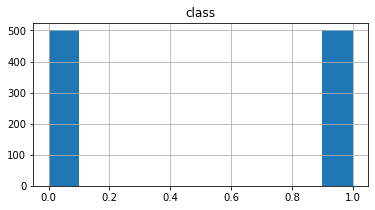

interactive(children=(IntSlider(value=499, description='index', max=999), Output()), _dom_classes=('widget-int…

In [25]:
# train setの分布と元画像をipywidgetsで表示

train_img_paths = util.find_img_files(train_data_dir)
train_img_class = [pathlib.Path(p).parent.stem for p in train_img_paths]
df_train_path = pd.DataFrame({'class':train_img_class, 'path':train_img_paths})

variants = {'Cat':0, 'Dog':1}
df_train_path['class'] = df_train_path['class'].replace(variants)

df_train_path[['class']].hist(figsize = (6, 3))
util.ipywidgets_show_img(df_train_path['path'], figsize=(6, 6))

In [5]:
def check_gen(gen):
    """ generatorの画像確認 """
    from PIL import Image
    import matplotlib.pyplot as plt
    import numpy as np
    %matplotlib inline
    x,y = next(gen)
    if isinstance(y, list):
        y = np.array(y)
    print(f"x.shape: {x.shape}")
    print(f"y.shape: {y.shape}")
    #print(f"y:\n{y}")
    print(f"y[0]: {y[0]}")
    util.plot_5imgs(x)
    return x,y

In [6]:
d_cls = get_train_valid_test.LabeledDataset([img_rows, img_cols, channels]
                                            , batch_size, valid_batch_size=val_batch_size, test_batch_size=test_batch_size
                                            , train_samples=train_samples, valid_samples=val_samples, test_samples=test_samples)

d_cls.create_my_generator_flow_from_directory(train_data_dir
                                              , classes
                                              , valid_data_dir=validation_data_dir
                                              , test_data_dir=test_dir
                                              , color_mode='rgb'
                                              , class_mode='categorical'
                                              , my_IDG_options=my_IDG_options
                                              , is_valid_grayscale=False # validation generatorをグレースケール化するか
                                             )

train_steps_per_epoch : 20
valid_steps_per_epoch : 8
test_steps_per_epoch : 1
my_IDG_options: {'rescale': 0.00392156862745098, 'random_erasing_prob': 0.5, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True, 'randaugment_N': 3, 'randaugment_M': 4}
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


(<generator object MyImageDataGenerator.flow_from_directory at 0x0000023820FBFA48>,
 <keras_preprocessing.image.directory_iterator.DirectoryIterator at 0x23810c4a608>)

Found 1000 images belonging to 2 classes.
x.shape: (50, 100, 100, 3)
y.shape: (50, 2)
y[0]: [1. 0.]
Num_Images:  50


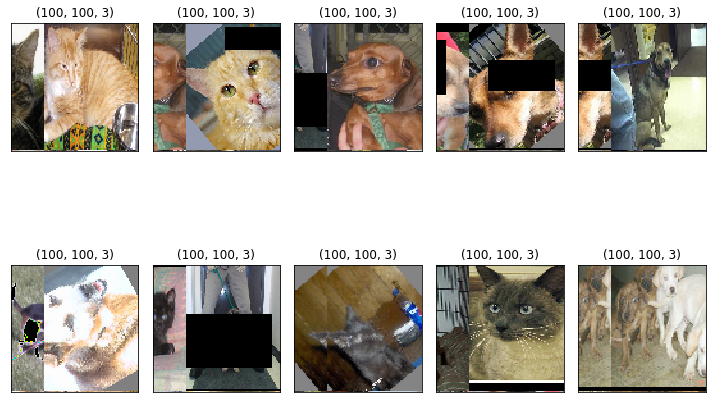

<Figure size 432x288 with 0 Axes>

In [7]:
x,y = check_gen(d_cls.train_gen)

x.shape: (50, 100, 100, 3)
y.shape: (50, 2)
y[0]: [1. 0.]
Num_Images:  50


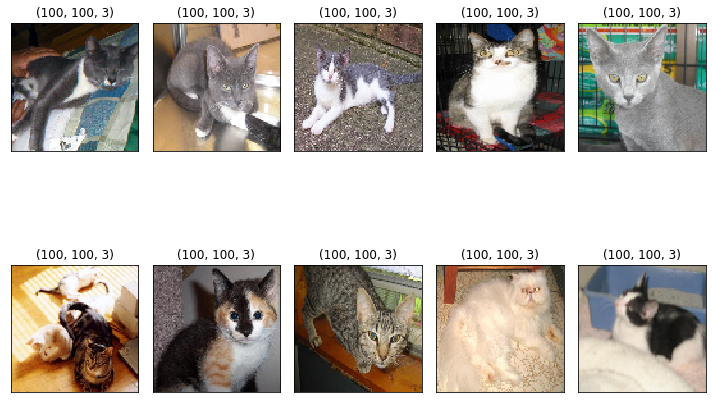

<Figure size 432x288 with 0 Axes>

In [8]:
x,y = check_gen(d_cls.valid_gen)

x.shape: (50, 100, 100, 3)
y.shape: (50, 2)
y[0]: [1. 0.]
Num_Images:  50


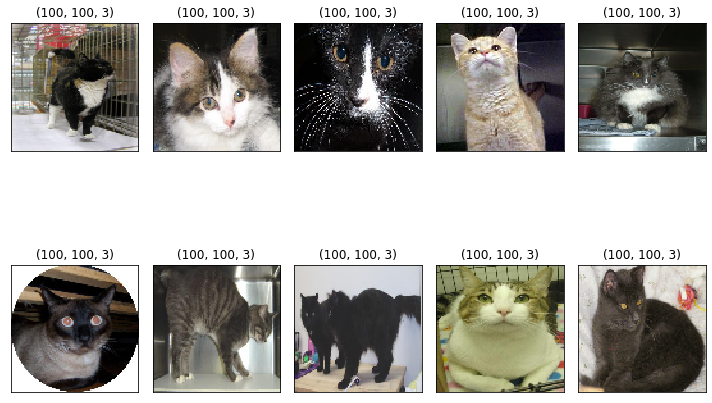

<Figure size 432x288 with 0 Axes>

In [9]:
x,y = check_gen(d_cls.test_gen)

#### model

In [11]:
# loss
loss = 'categorical_crossentropy'
metrics = ['accuracy']
activation = 'softmax'

# model
if model_path is None:
    if trainable != 'all':
        trainable = int(trainable)
    #model, orig_model = define_model.get_fine_tuning_model(output_dir, img_rows, img_cols, channels
    #                                                       , len(classes)
    #                                                       , choice_model, trainable
    #                                                       , fcs=fcs, drop=drop
    #                                                       , is_add_batchnorm=is_add_batchnorm
    #                                                       , l2_rate=l2_rate
    #                                                       , activation=activation
    #                                                       , gpu_count=len(gpus.split(','))
    #                                                       , skip_bn=is_skip_bn
    #                                                      )
    model = define_model.create_kuzushiji_best_network([img_rows, img_cols, channels], num_classes=len(classes))
else:
    model = keras.models.load_model(model_path, compile=False)
    
optim = define_model.get_optimizers(choice_optim, lr=lr)
model.compile(loss=loss, optimizer=optim, metrics=metrics)

---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True


In [12]:
define_model.print_model_summary(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 50, 16)   192         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 16)   768         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 50, 50, 16)   1728        input_1[0][0]                    
______________________________________________________________________________________________

81 add_7 True
82 conv2d_28 True
83 batch_normalization_24 True
84 activation_13 True
85 conv2d_29 True
86 batch_normalization_25 True
87 add_8 True
88 conv2d_30 True
89 batch_normalization_26 True
90 activation_14 True
91 conv2d_31 True
92 batch_normalization_27 True
93 add_9 True
94 batch_normalization_28 True
95 activation_15 True
96 conv2d_32 True
97 batch_normalization_29 True
98 activation_16 True
99 conv2d_33 True
    weights.shape:(3, 3, 64, 512)
100 multiply_2 True
101 max_pooling2d_2 True
102 blur_pooling2d_2 True
103 conv2d_34 True
104 batch_normalization_30 True
105 conv2d_35 True
106 batch_normalization_31 True
107 activation_17 True
108 conv2d_36 True
109 batch_normalization_32 True
110 add_10 True
111 conv2d_37 True
112 batch_normalization_33 True
113 activation_18 True
114 conv2d_38 True
115 batch_normalization_34 True
116 add_11 True
117 conv2d_39 True
118 batch_normalization_35 True
119 activation_19 True
120 conv2d_40 True
121 batch_normalization_36 True
122 add_12 Tr

In [ ]:
# 最適な学習率探索. 後続処理実行する場合はデータとモデル再定義必要
#lr_finder.run(model, d_cls.train_gen, batch_size, d_cls.init_train_steps_per_epoch, output_dir=output_dir)

#### train

Epoch 1/30
19/20 [===========================>..] - ETA: 0s - loss: 11.3995 - accuracy: 0.4926
Epoch 00001: val_loss improved from inf to 11.75641, saving model to D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\val_loss_best.h5

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\val_accuracy_best.h5
20/20 [==============================] - 22s 1s/step - loss: 11.3687 - accuracy: 0.4960 - val_loss: 11.7564 - val_accuracy: 0.5000
Epoch 2/30
19/20 [===========================>..] - ETA: 0s - loss: 11.8332 - accuracy: 0.4937
Epoch 00002: val_loss did not improve from 11.75641

Epoch 00002: val_accuracy did not improve from 0.50000
20/20 [==============================] - 12s 612ms/step - loss: 11.8474 - accuracy: 0.4930 - val_loss: 11.7956 - val_accuracy: 0.5000
Epoch 3/30
19/20 [===========================>..] - ETA: 0s - loss: 11.7775 - accuracy: 0.4958
Epoch 00003: val_loss did n


Epoch 00020: val_accuracy did not improve from 0.50000
20/20 [==============================] - 15s 762ms/step - loss: 11.6654 - accuracy: 0.5010 - val_loss: 11.6638 - val_accuracy: 0.5000
Epoch 21/30
19/20 [===========================>..] - ETA: 0s - loss: 11.6965 - accuracy: 0.4947
Epoch 00021: val_loss improved from 11.66376 to 11.66115, saving model to D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\val_loss_best.h5

Epoch 00021: val_accuracy did not improve from 0.50000
20/20 [==============================] - 15s 747ms/step - loss: 11.7431 - accuracy: 0.4920 - val_loss: 11.6612 - val_accuracy: 0.5000
Epoch 22/30
19/20 [===========================>..] - ETA: 0s - loss: 11.6093 - accuracy: 0.5032
Epoch 00022: val_loss improved from 11.66115 to 11.65901, saving model to D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\val_loss_best.h5

Epoch 00022: val_accuracy did not improve from 0.50000
20/20 [==============================] - 15s 746ms/step 

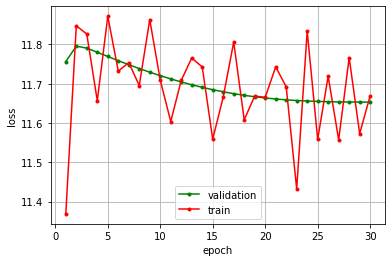

<Figure size 432x288 with 0 Axes>

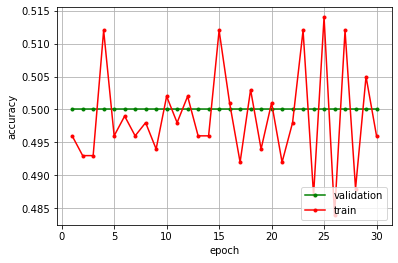

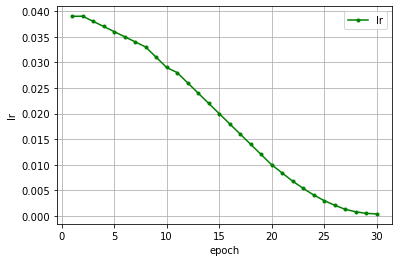

<Figure size 432x288 with 0 Axes>

In [13]:
def get_cb(output_dir:str, num_epoch:int) -> list:
    """ trainでつかうkerasのcallback取得 """
    cb = []
    # 学習率をエポック増やすごとにコサインカーブで上げ下げする. epochsはコサインカーブのほぼ半周期になるエポック数
    cb.append(my_callback.cosine_annealing(factor=lr_factor, epochs=num_epoch))
    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(output_dir, 'tsv_logger.tsv')))
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(output_dir, 'learning_curve.png')))
    # 各エポックでval_lossが最小となるモデル保存
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'val_loss_best.h5'), monitor='val_loss', save_best_only=True, verbose=1))
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'val_accuracy_best.h5'), monitor='val_accuracy', save_best_only=True, verbose=1, mode='max'))
    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=num_epoch//2, verbose=1))
    return cb

start_time = time.time()
history = model.fit_generator(
    d_cls.train_gen
    , steps_per_epoch = train_samples//batch_size
    , epochs = num_epoch
    , validation_data = d_cls.valid_gen
    , validation_steps = val_samples//val_batch_size
    , verbose = 1 # 1:ログをプログレスバーで標準出力 2:最低限の情報のみ出す
    , callbacks = get_cb(output_dir, num_epoch)
    )
end_time = time.time()
print("Elapsed Time : {:.2f}sec".format(end_time - start_time))

# lossやaccの学習履歴のグラフ保存
plot_log.plot_results(output_dir, os.path.join(output_dir, 'tsv_logger.tsv'), acc_metric=metrics[0])

#### predict

,Filename,PredictionLabel,PredictionScore
0,Cat\10024.jpg,Dog,3.15e+02
1,Cat\10046.jpg,Dog,6.96e+02
2,Cat\10070.jpg,Dog,6.34e+02
3,Cat\10122.jpg,Dog,2.76e+02
4,Cat\10136.jpg,Dog,4.04e+02


y_pred_list_str: ['Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Do

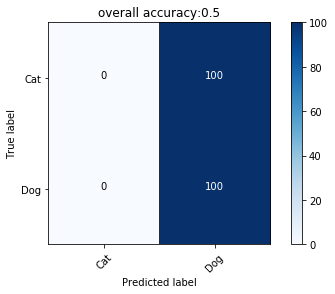

<Figure size 432x288 with 0 Axes>

In [14]:
# Custom Functionを使ったmodelを別環境で使用するには、modelをロードする際に引数として、[custom_objects]を指定するがある
# https://qiita.com/tkinjo1/items/51f9e2d0d9c4659bde8a
load_model = keras.models.load_model(os.path.join(output_dir, 'val_loss_best.h5')
                                     , custom_objects={'BlurPooling2D':pooling.BlurPooling2D
                                                       , 'GeM2D':pooling.GeM2D})
#load_model = keras.models.load_model(os.path.join(output_dir, 'val_loss_best.h5'))

# generatorで全件予測
pred_df = base_predict.pred_classes_generator(load_model, d_cls.test_gen, classes_list=class_name)
pred_df.to_csv(os.path.join(output_dir, 'pred.tsv'), sep='\t')
display(pred_df.head())

# 予測結果のデータフレームから混同行列作成
base_predict.conf_matrix_from_pred_classes_generator(pred_df, classes, output_dir)

#### Grad-CAM

In [15]:
out_grad_cam_dir = os.path.join(output_dir, 'grad_cam/test')
os.makedirs(out_grad_cam_dir, exist_ok=True)

for i,p in tqdm(enumerate(util.find_img_files(test_dir))):
                
    # 10枚ごとにモデル再ロード
    if i % 10 == 0:
        keras.backend.clear_session() # セッションのクリア
        keras.backend.set_learning_phase(0) # Test時には0にセット DropoutやBatchNormありmodelのときはロード前にこれがないとGradCamエラーになる
        model = keras.models.load_model(os.path.join(output_dir, 'val_loss_best.h5')
                                        , custom_objects={'BlurPooling2D':pooling.BlurPooling2D
                                                          , 'GeM2D':pooling.GeM2D})
        #model = keras.models.load_model(os.path.join(output_dir, 'val_loss_best.h5'), compile=False) # モデルロード
    
    grad_cam_img = grad_cam.image2gradcam(model, p, out_dir=out_grad_cam_dir)
    
    if i == 15:
        break

out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10024_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10046_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10070_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10122_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10136_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10141_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10185_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10283_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf

Num_Images:  32


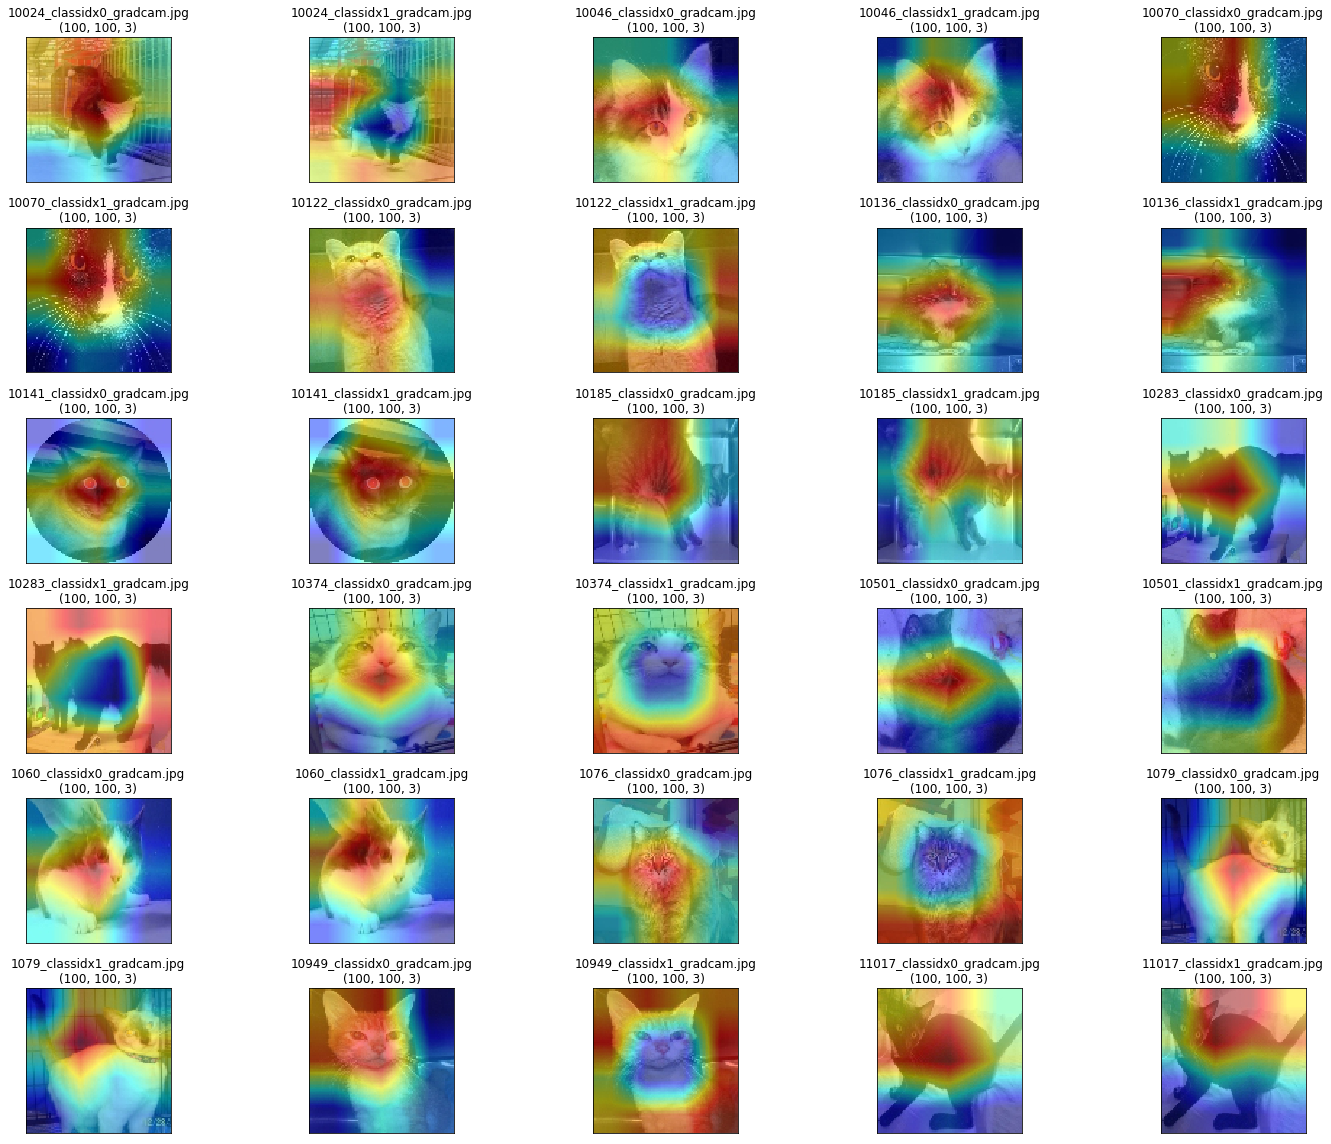

<Figure size 432x288 with 0 Axes>

In [16]:
img_list = glob.glob(out_grad_cam_dir+'/*.jpg')
num = 30
util.plot_5imgs(img_list
                , plot_num=num
                , figsize=(10*2, 8*2)
                , labels=[str(pathlib.Path(p).name) for p in img_list[:num]])